# **Computer Vision Final Project**
## A Deep Dive Into Artistic Style Transfer Between Images

### By Emi Yoshikawa, Zane Priebe, and Joanie Foley

# Imports

In [15]:
import copy

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as transforms

# Choose device to run the network on 

GPU is preferred as it saves training time, but if not available then use CPU. Make sure to go to "Runtime" settings and in "Change Runtime Type" assign GPU to "hardware Accelerator." 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Switch home directory to be in Google Drive 

We are uploading and using images from our Google Drive so we switch our home directory to be in the Google Drive folder/directory we are keeping this project and images in. 

In [17]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks"

  # Create drive_root if it doesn't exist
  # We should never enter this case, but just in case
  create_drive_root = True
  if create_drive_root:
    print("Making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("Changing directory to ", drive_root)
  %cd $drive_root

We're running Colab
Mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Making sure  /content/gdrive/My Drive/Colab Notebooks  exists.
Changing directory to  /content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks


# Load Images
We're using an image by Edvard Munch for style and a picture of Baby Yoda for content. These images are located in the `Vision/images` folder within our `Colab Notebooks` folder. Feel free to modify the paths to use images of your choice.

Next, we can't just load our images and feed them into the model. First we need to do some preprocessing to make them compatible
1.   Resize images to have the same dimensions (512 x 512 if using GPU and 128 x 128 if using CPU) 
2.   Convert images to PyTorch tensors

Yay now our images are ready! Last, we want to create our "output" image that we will be training later on to create our desired output image. We use just a copy of our content image to create this "output" image.




In [18]:
image_size = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

def image_loader(image_name):
    image = Image.open(image_name)
    # resize the images and transform them to tensors
    loader = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
    # need to add this so batch size is accounted for (fake dimension)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_image = image_loader("./Vision/images/edvard.jpg")
content_image = image_loader("./Vision/images/baby_yoda.jpg")

print("style image size: ", style_image.size())
print("content image size: ", content_image.size())

assert style_image.size() == content_image.size(), \
    "style and content images need to be the same size"

# copy of content image to produce our output image:
output_image = content_image.clone().requires_grad_(True)

style image size:  torch.Size([1, 3, 512, 512])
content image size:  torch.Size([1, 3, 512, 512])


# Check and Display Images

We must first convert a copy of the images to PIL format. Then we can display the images and check if they were imported correctly. We check all three images to make sure they are as expected. 

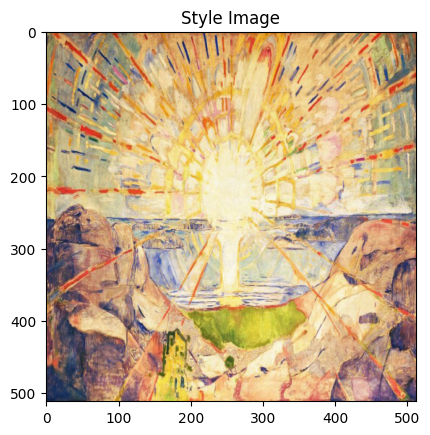

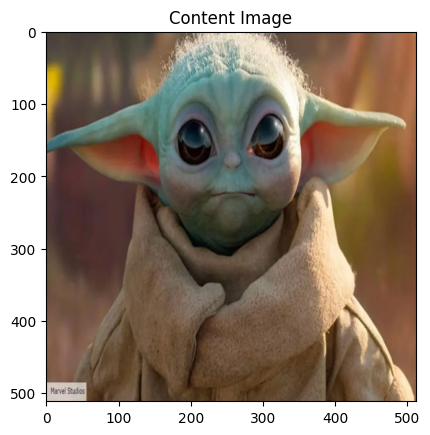

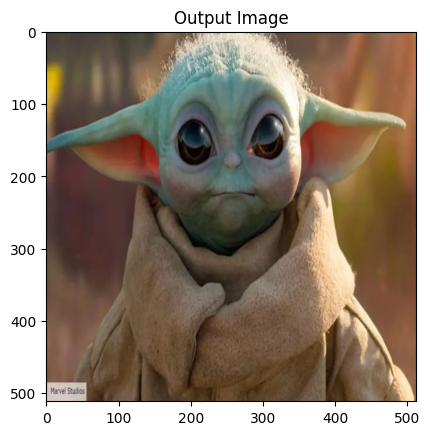

In [19]:
unloader = transforms.ToPILImage() 

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0) 
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_image, title='Style Image')

plt.figure()
imshow(content_image, title='Content Image')

plt.figure()
imshow(output_image, title='Output Image')

# Import Vgg19 model

We are using a pretrained neural network, specifically, a 19 layer VGG network (Vgg19). We only need to use the convolution neural network component from the vgg19 model, so we only import vgg19.features


In [20]:
model = models.vgg19(pretrained=True).features.to(device).eval()

# Get Feature Representations
We want the feature representations of the intermediate layers as they can describe the style and content of the input image. We can accomplish this by getting the feature representations of only the layers conv1_1, conv2_1, conv3_1, con4_1, and conv5_1 and then elimating all the other layers beyond conv5_1.

In [21]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        # these are index values of the desired conv layers listed above
        self.desired_features = ['0','5','10','19','28'] 
        # elimante all other layers from feauture of the model
        self.model = models.vgg19(pretrained = True).features[:29]
    
    def forward(self,x):
        #array that wil hold the feature reps from the chosen layers
        features = []
        for curr_layer, layer in enumerate(self.model):
            # store feature reps of the layer
            x = layer(x)
            # append only desired feature reps
            if (str(curr_layer) in self.desired_features):
                features.append(x)
                
        return features

# Initialize the model and variables

Load up the model, initalize its parameters, and initalize Adam optimizer. 

*We choose to do this here as alpha and beta are needed to calculate the total loss below.*

In [22]:
model = VGG19().to(device).eval() 

epoch = 1000
lr = 0.01
alpha = 1
beta = 0.01

# using adam optimizer to update the input image not the model parameter 
optimizer=optim.Adam([output_image],lr=lr)


# Content Loss

The content loss computes the (weighted) content distance for a single layer. This is found by using two feature reps of a single layer:
*   Fi: the input image feature rep
*   Fc: the content image feature rep
and then find the distance by taking the mean square error between the two sets of feature reps:
||Fi - Fc||^2



In [23]:
def calc_content_loss(input_features, content_features):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_loss = torch.mean((input_features - content_features) ** 2)
    return content_loss

# Style Loss

To compute style loss, for each layer of the network, we create a feature space that represents the correlation between different filter responses. 

These different filter responses are calculated by the Gram matrix. Thus, the style loss of a layer is the squared error between the gram matrices (of the intermediate reps) of the style image and the input image. Then we take the mean to account for the weight factor. 

In [24]:
def calc_style_loss(input, style):
    #Calculating the gram matrix for the input and style image 
    batch_size, channel, height, width = input.shape

    gram_matrix_input = torch.mm(input.view(channel,height*width),input.view(channel,height*width).t())
    gram_matrix_style = torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    style_loss = torch.mean((gram_matrix_input - gram_matrix_style) ** 2)
    return style_loss

# Calculate Total Loss

Calculate the total loss by adding up the style and content loss for all the intermediate layers

In [25]:
def calculate_total_loss(input_features, content_feautes, style_featues):
    style_loss = content_loss = 0
    for input, content, style in zip(input_features, content_feautes, style_featues):
        content_loss += calc_content_loss(input, content)
        style_loss += calc_style_loss(input, style)
  
    #calculating the total loss of the epoch
    total_loss= alpha * content_loss + beta * style_loss 
    return total_loss

# Train the Model 

Training the model follows a simple strategy...
1.   Iterate over the number of epochs
2.   Extract feature reps of the intermediate layers of the style, content, and input image using Vgg19 model
3. Calculate the total loss 
4. Set the gradients to 0 
5. Backpropgate the total loss and update the pixel vals of the input image
6. Print the total loss every 100 epochs
7. Display final image!





tensor(1905674.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38162.9961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28933.5234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22898.2461, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18576.2344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15268.5244, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12160.4639, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11047.6455, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7898.2607, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14393.6299, device='cuda:0', grad_fn=<AddBackward0>)


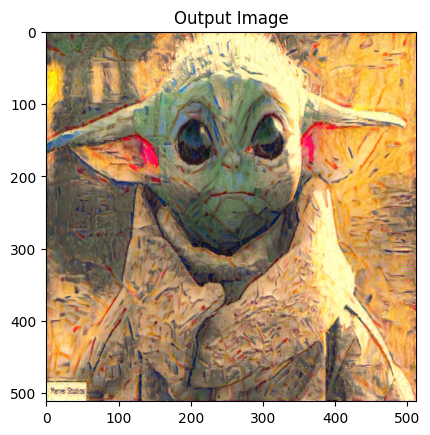

In [26]:
#iterating for 1000 times
for e in range (epoch):
    #extracting the features of generated, content and the original required for calculating the loss
    content_feautes = model(content_image)
    style_featues = model(style_image)
    input_features = model(output_image)
    
    #iterating over the activation of each layer, calculate the loss, add it to the content and style loss
    total_loss = calculate_total_loss(input_features, content_feautes, style_featues)

    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    with torch.no_grad():
      output_image.clamp_(0, 1)

    #print the loss after every 100 epochs
    if(e % 100 == 0):
        print(total_loss)

plt.figure()
imshow(output_image, title='Output Image')